# Vytváření datasetu

(512, 512)
(128, 128)
(512, 512)
(128, 128)
(512, 512)
(128, 128)


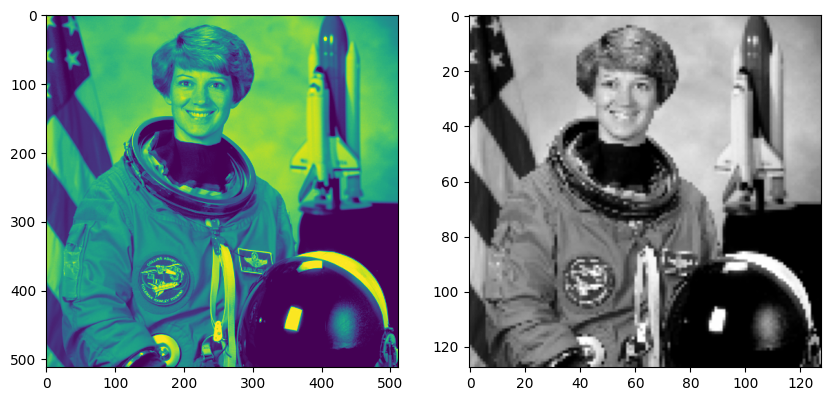

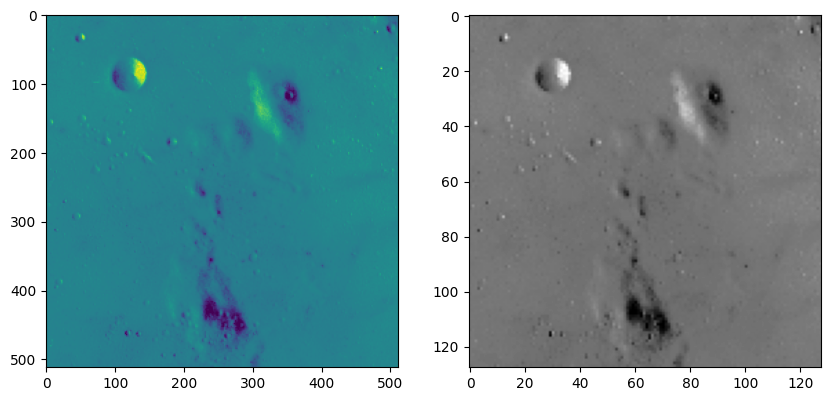

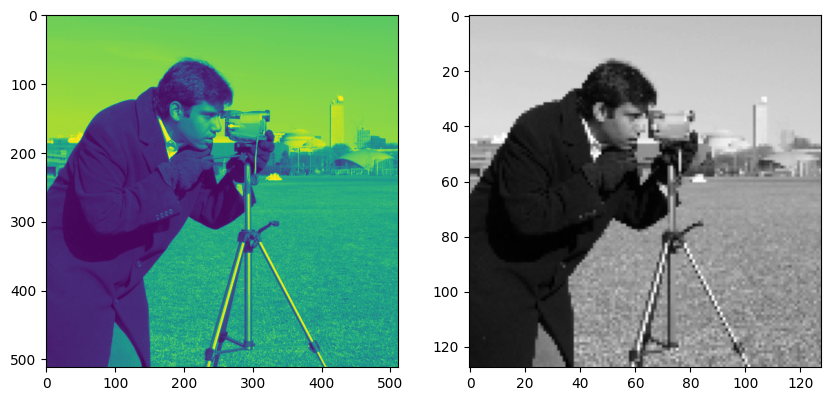

In [24]:
from skimage import data
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte, random_noise
import skimage
import numpy as np
import pickle

images = [rgb2gray(data.astronaut()), data.moon(), data.camera()]
processed_images = []
for image in images:
    processed_image = img_as_ubyte(image)[::4, ::4]
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    ax0.imshow(image)
    ax1.imshow(processed_image, cmap='gray')
    print(image.shape)
    print(processed_image.shape)
    processed_images.append(processed_image)


## Přidání vertikálního, diagonálního a periodického šumu

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


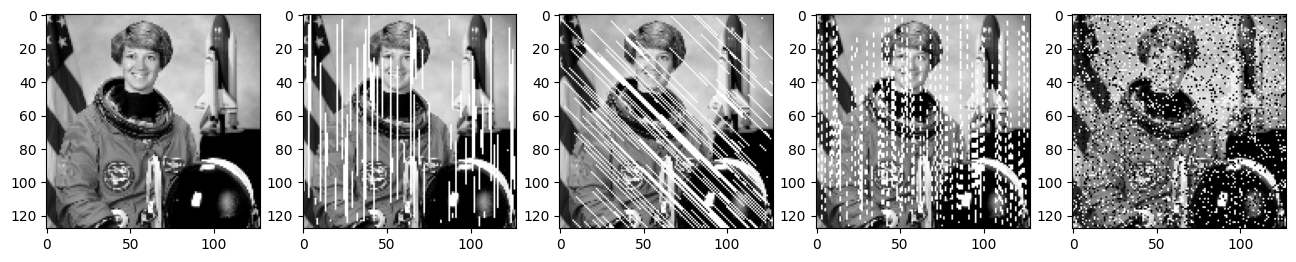

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0 255 ...   0 255   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


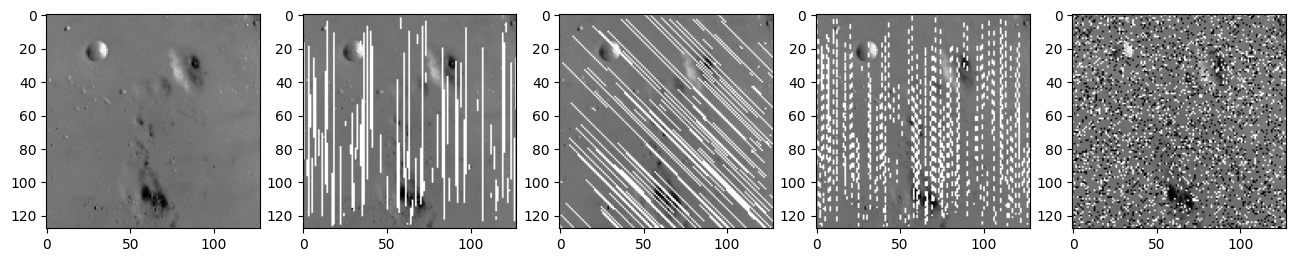

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0 255 ...   0   0   0]
 [  0   0 255 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


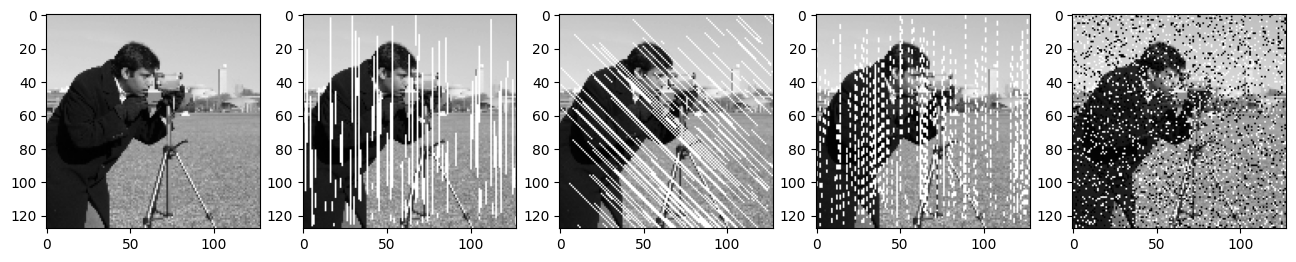

In [ ]:
def add_vertical_lines(img, percentage):
    """Add vertical lines to the image."""
    height, width = img.shape
    affected_pixels = 0
    max_affected_pixels = int(percentage * width * height)
    mask = np.zeros_like(img)
    while affected_pixels < max_affected_pixels:
        column = np.random.randint(0, width)
        # randomly set the row from which to start the vertical line
        start_row = np.random.randint(0, height)
        end_row = np.random.randint(start_row, height)
        img[start_row:end_row, column] = 255  # set the pixel values to 255 (white)
        mask[start_row:end_row, column] = 255
        affected_pixels += end_row - start_row
    return img, mask

def add_diagonal_lines(img, percentage):
    """Add diagonal lines to the image."""
    height, width = img.shape
    affected_pixels = 0
    max_affected_pixels = int(percentage * width * height)
    mask = np.zeros_like(img)
    while affected_pixels < max_affected_pixels:
        start_col = np.random.randint(0, width) # 200
        start_row = np.random.randint(0, height) # 210
        length = np.random.randint(0, width - start_col) # 70
        clipped_length = min(min(height - start_row - 1, width - start_col - 1), length)
        end_col = clipped_length + start_col
        end_row = clipped_length + start_row
        rr, cc = skimage.draw.line(start_row, start_col, end_row, end_col)
        img[rr, cc] = 255  # set the pixel values to 255 (white)
        mask[rr, cc] = 255
        affected_pixels += len(rr)
    return img, mask

def add_periodic_lines(img, percentage):
    """Add periodic vertical lines to the image."""
    height, width = img.shape
    affected_pixels = 0
    max_affected_pixels = int(percentage * width * height)
    period = 3
    mask = np.zeros_like(img)
    while affected_pixels < max_affected_pixels:
        column = np.random.randint(0, width)
        # randomly set the row from which to start the vertical line
        start_row = np.random.randint(0, height)
        end_row = np.random.randint(start_row, height)
        # img[start_row:end_row, column,] = 255  # set the pixel values to 255 (white)
        current_row = start_row
        gap = False
        while current_row < end_row:
            current_end_row = min(current_row + period, end_row)
            if gap:
                current_row = current_end_row
                gap = False
                continue
            img[current_row:current_end_row, column] = 255  # set the pixel values to 255 (white)
            mask[current_row:current_end_row, column] = 255
            affected_pixels += current_end_row - current_row
            current_row = current_end_row
            gap = True
    return img, mask

def add_sap(img, percantage):
    mask = np.full_like(img, fill_value=127)
    mask = img_as_ubyte(random_noise(mask, mode='s&p', amount=percantage))
    # apply the mask
    new_img = img.copy()
    for i in range(len(new_img)):
        for j in range(len(new_img[i])):
            if mask[i][j] == 0:
                new_img[i][j] = 0
            if mask[i][j] == 255:
                new_img[i][j] = 255
    # convert the mask to mask map
    for i in range(len(mask)):
        for j in range(len(mask[i])):
            if mask[i][j] == 0 or mask[i][j] == 255:
                mask[i][j] = 255
            else:
                mask[i][j] = 0
    return new_img, mask


noise_percentage = 0.2
data = {}
dataset_names = ["astronaut", "moon", "camera"]
for processed_image, name in zip(processed_images, dataset_names):
    vertical_noise_img, vertical_noise_mask = add_vertical_lines(processed_image.copy(), noise_percentage)
    diagonal_noise_img, diagonal_noise_mask = add_diagonal_lines(processed_image.copy(), noise_percentage)
    periodic_noise_img, periodic_noise_mask = add_periodic_lines(processed_image.copy(), noise_percentage)
    sap_noise_img, sap_noise_mask = add_sap(processed_image.copy(), noise_percentage)
    
    data[name] = {
        "name": name,
        "noise_percentage": noise_percentage,
        "image_shape": processed_image.shape,
        "image_type": "grayscale",
        "original": processed_image,
        "vertical_noise": vertical_noise_img,
        "vertical_noise_mask": vertical_noise_mask,
        "diagonal_noise": diagonal_noise_img,
        "diagonal_noise_mask": diagonal_noise_mask,
        "periodic_noise": periodic_noise_img,
        "periodic_noise_mask": periodic_noise_mask,
        "sap_noise": sap_noise_img,
        "sap_noise_mask": sap_noise_mask,
    }

pickle.dump(data, open("datasets/dataset.pkl", "wb"))


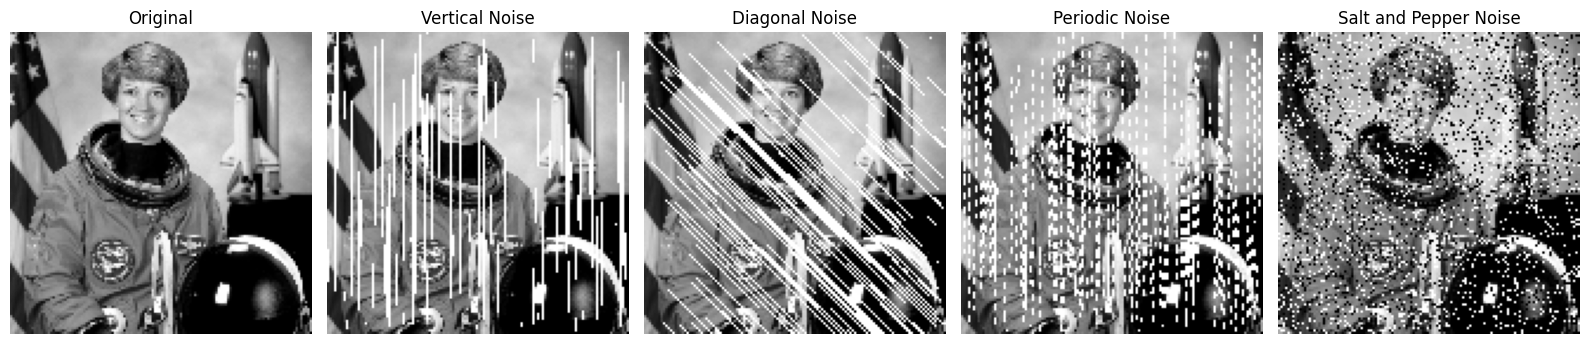

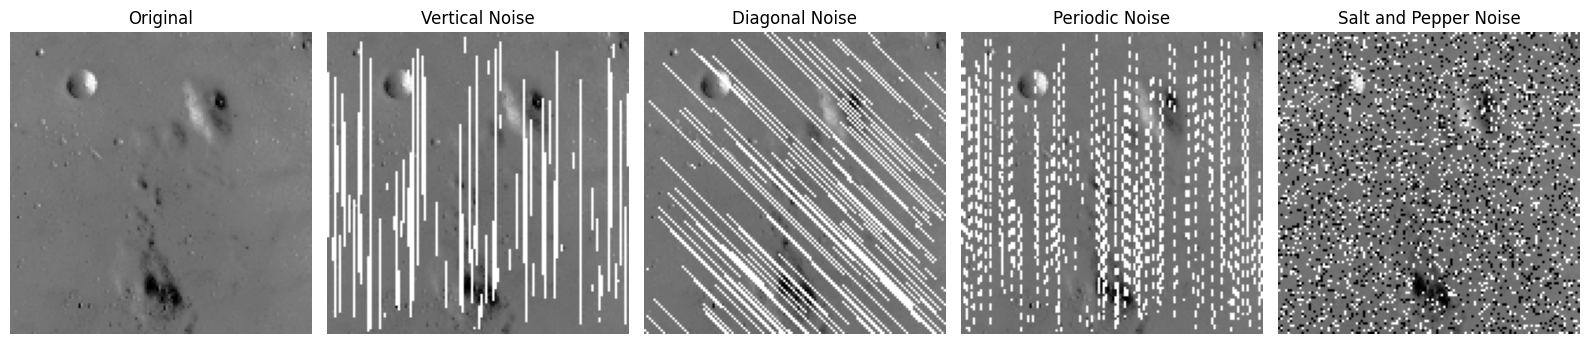

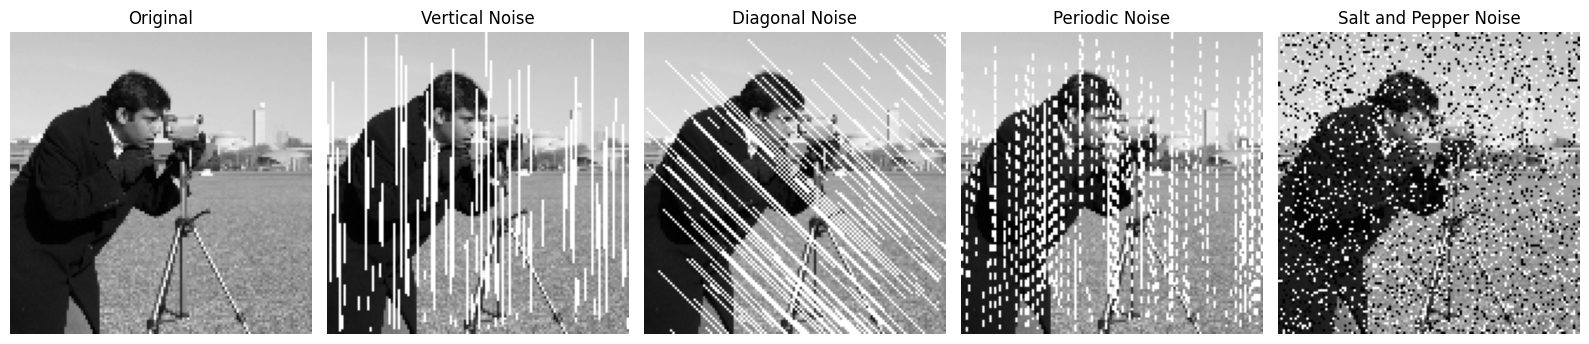

In [37]:
# load the dataset from the pickle file
data = pickle.load(open("datasets/dataset.pkl", "rb"))


for name in dataset_names:
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 8))
    original_image = data[name]["original"]
    ax1.imshow(original_image, cmap='gray')
    vertical_noise_img = data[name]["vertical_noise"]
    ax2.imshow(vertical_noise_img, cmap='gray')
    diagonal_noise_img = data[name]["diagonal_noise"]
    ax3.imshow(diagonal_noise_img, cmap='gray')
    periodic_noise_img = data[name]["periodic_noise"]
    ax4.imshow(periodic_noise_img, cmap='gray')
    sap_noise_img= data[name]["sap_noise"]
    ax5.imshow(sap_noise_img, cmap='gray')
    ax1.set_title("Original")
    ax2.set_title("Vertical Noise")
    ax3.set_title("Diagonal Noise")
    ax4.set_title("Periodic Noise")
    ax5.set_title("Salt and Pepper Noise")
    for ax in (ax1, ax2, ax3, ax4, ax5):
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    